<a href="https://colab.research.google.com/github/azz2k/vendor_challenge/blob/main/vendor_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
* To make my life easier I will remove everything but [a-zA-Z0-9] and whitespaces
* For now I will use a bag-of-words approach as I have limited time

# libraries, constants, etc.

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import sklearn.model_selection

import seaborn as sns
from matplotlib import pyplot as plt

import nltk

This should later be put into: requirements installations (in separate requirements file)

In [2]:
# Punkt sentence tokenizer
nltk.download("punkt")
# Word List Corpus
nltk.download("words")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# read data


In [3]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
products_raw_df = pd.read_parquet("/content/drive/MyDrive/Data Science/products.parquet.gz")
products_raw_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21z6tu,Cheese Tofu,None,116
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24
...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,None,22
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22


# look at target

In [5]:
products_raw_df["order_count"].describe()

count    633148.000000
mean          9.482963
std          24.025783
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        1386.000000
Name: order_count, dtype: float64

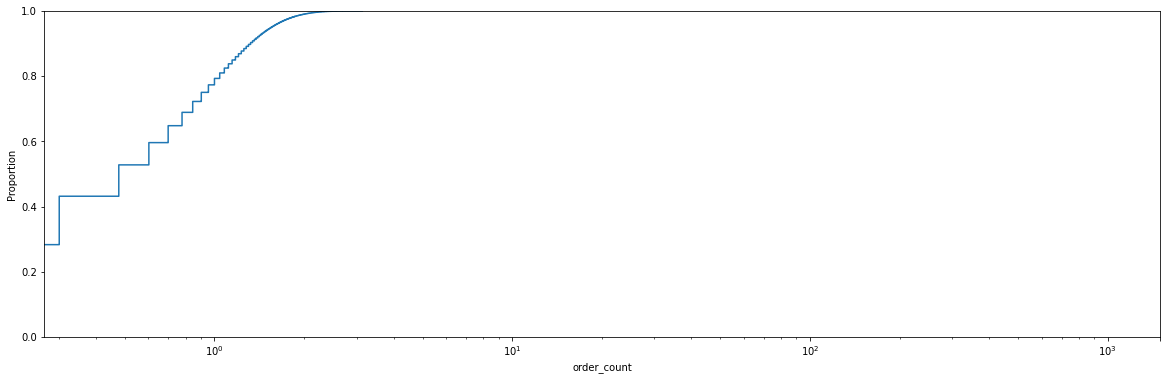

In [6]:
# plot the order count ecdf
fig, ax = plt.subplots(1, 1, figsize = (20, 6))
sns.ecdfplot(
    data=products_raw_df,
    x="order_count",
    ax=ax,
    log_scale=True
)
ax.set_xticks([1, 10, 100, 1000, 1500])
plt.show()

That is a target distribution we don't really want to see. Most orders are less than five and only a few orders have a significant number. We need to sample from more than just one month to make useful predictions.

# data cleanup

## train test split

In [7]:
# sample data for testing
products_sample_raw_df = products_raw_df.copy() #sample(20000)

In [8]:
# train test split
products_sample_raw_train_df, products_sample_raw_test_df = sklearn.model_selection.train_test_split(products_sample_raw_df, test_size=0.2)

## data normalization

In [9]:
# use these keys to normalize
primary_keys = ["product_id", "vendor_id", "vendor_geohash"]

In [10]:
# split into a more normalized form
products_raw_df = products_sample_raw_train_df[primary_keys + ["order_count"]].copy()
products_name_raw_df = products_sample_raw_train_df[primary_keys + ["product_name"]].copy().rename({"product_name": "text"}, axis=1)
products_description_raw_df = products_sample_raw_train_df[primary_keys + ["product_description"]].copy().rename({"product_description": "text"}, axis=1)

## basic cleanup

In [11]:
products_df = products_raw_df.copy()
products_name_df = products_name_raw_df.copy()
products_description_df = products_description_raw_df.copy()

In [12]:
# drop empty text
products_name_df.dropna(inplace=True)
products_description_df.dropna(inplace=True)

# replace everything but basic chars for now
products_name_df["text"].replace("[^a-zA-Z0-9 ]", " ", inplace=True, regex=True)
products_description_df["text"].replace("[^a-zA-Z0-9 ]", " ", inplace=True, regex=True)

# remove single and double characters
products_name_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)
products_name_df["text"].replace("(^| )..( |$)", " ", inplace=True, regex=True)
products_description_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)
products_description_df["text"].replace("(^| )..( |$)", " ", inplace=True, regex=True)

# remove all double whitespaces
products_name_df["text"].replace("[ ]+", " ", inplace=True, regex=True)
products_description_df["text"].replace("[ ]+", " ", inplace=True, regex=True)

# drop empty text
products_name_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_name_df = products_name_df[products_name_df["text"] != ""]

products_description_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_description_df = products_description_df[products_description_df["text"] != ""]

In [13]:
# to lower
products_name_df["text"] = products_name_df["text"].str.lower()
products_description_df["text"] = products_description_df["text"].str.lower()

In [14]:
products_name_df

,product_id,vendor_id,vendor_geohash,text
370373,370373,2671,w21zu1b,sambal sweet potato leaf
604160,604160,55,w21ze1r,daucy sweet corn 340g
593393,593393,1271,w21z7qd,trio pancakes
39784,39784,1572,w23b1tq,matcha boba milk
13441,13441,2532,w21z601,ebi fried teriyaki chicken bento
...,...,...,...,...
351087,351087,573,w21z74k,vegetable biryani
358430,358430,4860,w21zkkv,fishball soup
37901,37901,4012,w21zt11,thai green milk tea
486547,486547,2772,w23b4u4,ribena ice


In [15]:
products_description_df

,product_id,vendor_id,vendor_geohash,text
115131,115131,9830,w21ztwt,feel peckish for chicken then try our oven roa...
9114,9114,1358,w21zujm,asam laksa noodles topped with fishball onion ...
339176,339176,8911,w21z6vj,signature lucknawi paratha made an inverted gr...
191290,191290,5814,w23b1tq,dermatologically tested and proven kills germs...
184525,184525,1037,w21z7qn,chicken your thing our mcwings will send you ...
...,...,...,...,...
363195,363195,9394,w21z62w,piece
246191,246191,5847,w21ze4s,mcdonald icon our apple pies have been meltin...
316904,316904,598,w23b1tr,spicy chicken mcnuggets 12pc served together w...
351087,351087,573,w21z74k,assorted fresh vegetable with saffron flavoure...


## tokenization and stemming

In [16]:
products_name_token_df = products_name_df.copy()
products_description_token_df = products_description_df.copy()

In [17]:
# tokenization
products_name_token_df["text_tokens"] = products_name_token_df["text"].transform(nltk.word_tokenize)
products_description_token_df["text_tokens"] = products_description_token_df["text"].apply(nltk.word_tokenize)

In [18]:
# add a position index and explode
products_name_token_df["idx"] = 1
products_name_token_df = products_name_token_df.explode("text_tokens")
products_name_token_df["idx"] = products_name_token_df.groupby(primary_keys)["idx"].cumsum()

products_description_token_df["idx"] = 1
products_description_token_df = products_description_token_df.explode("text_tokens")
products_description_token_df["idx"] = products_description_token_df.groupby(primary_keys)["idx"].cumsum()

In [19]:
# stemming
snowball = nltk.stem.SnowballStemmer(language="english")
products_name_token_df["text_tokens_stemmed"] = products_name_token_df["text_tokens"].apply(lambda x: snowball.stem(x))
products_description_token_df["text_tokens_stemmed"] = products_description_token_df["text_tokens"].apply(lambda x: snowball.stem(x))

## filter english items

The general idea here is to count the fraction of english words in name and description and to use this in some way to filter english items.

### checking if tokens are english and couting etc.

In [20]:
# check if text_tokens are in words corpus
words = nltk.corpus.words.words()
products_name_token_df["is_english"] = products_name_token_df["text_tokens"].isin(words)
products_description_token_df["is_english"] = products_description_token_df["text_tokens"].isin(words)

In [21]:
products_english_df = products_df.copy()

# count english words and total words for product name
products_english_df = products_english_df.merge(
    products_name_token_df.groupby(primary_keys)["is_english"].sum().reset_index().rename({"is_english": "name_is_english"}, axis=1), 
    on=primary_keys, 
    how="left")
products_english_df = products_english_df.merge(
    products_name_token_df.groupby(primary_keys)["is_english"].size().reset_index().rename({"is_english": "name_n_words"}, axis=1), 
    on=primary_keys, 
    how="left")

# count english words and total words for product description
products_english_df = products_english_df.merge(
    products_description_token_df.groupby(primary_keys)["is_english"].sum().reset_index().rename({"is_english": "description_is_english"}, axis=1), 
    on=primary_keys, 
    how="left")
products_english_df = products_english_df.merge(
    products_description_token_df.groupby(primary_keys)["is_english"].size().reset_index().rename({"is_english": "description_n_words"}, axis=1), 
    on=primary_keys, 
    how="left")

# replace nans etc. from empty text and cast back to int
for col in ["name_is_english", "name_n_words", "description_is_english", "description_n_words"]:
    products_english_df[col] = products_english_df[col].replace(np.nan, 0).astype(int)

In [22]:
# calculate the actual frequency = score
products_english_df["total_is_english"] = products_english_df["name_is_english"] + products_english_df["description_is_english"]
products_english_df["total_n_words"] = products_english_df["name_n_words"] + products_english_df["description_n_words"]
products_english_df["english_score"] = products_english_df["total_is_english"] / products_english_df["total_n_words"]

In [23]:
# drop ones with no english score
products_english_df = products_english_df[~products_english_df["english_score"].isna()]

### filter metric exploration

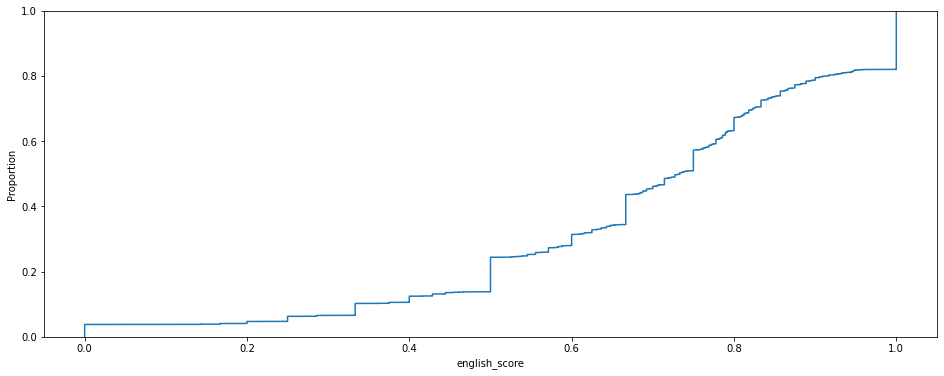

In [24]:
# plot the english score ecdf
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.ecdfplot(
    data=products_english_df,
    x="english_score",
    ax=ax
)
plt.show()

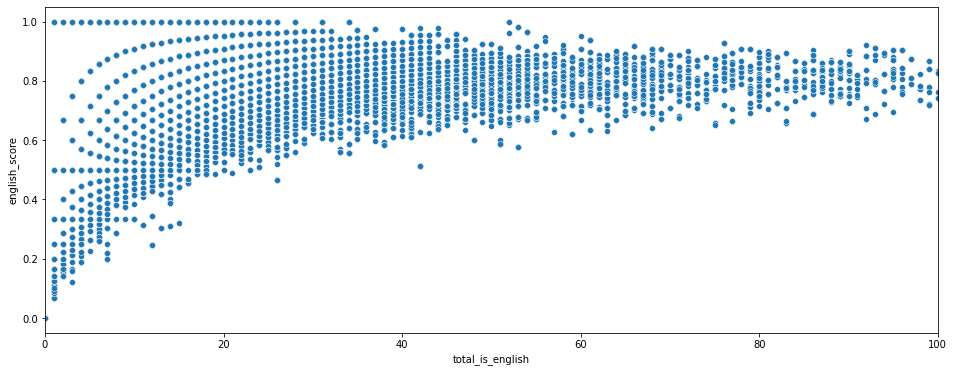

In [25]:
# plot the english score as a function of english words
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.scatterplot(
    data=products_english_df,
    x="total_is_english",
    y="english_score",
    ax=ax
)
ax.set_xlim(0, 100)
plt.show()

In [26]:
products_raw_df.merge(products_english_df[(products_english_df["english_score"] > 0.2) & (products_english_df["english_score"] < 0.3)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,order_count
0,219836,5241,w21zsd2,1
1,47216,465,w21zurm,48
2,440387,9740,w21z9kh,5
3,508619,106,w21z6cf,7
4,521741,3179,w23b51b,8
...,...,...,...,...
9383,340506,5160,w21z744,3
9384,142148,6112,w21zffe,1
9385,46716,131,w23bhdd,110
9386,347947,6766,w21ze06,3


In [27]:
products_raw_df.merge(products_english_df[(products_english_df["english_score"] > 0.6) & (products_english_df["english_score"] < 0.7)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,order_count
0,39784,1572,w23b1tq,40
1,388787,440,w21zujm,3
2,584473,1932,w23b4uy,13
3,260023,12888,w21zefw,2
4,191290,5814,w23b1tq,1
...,...,...,...,...
71182,93297,9265,w21zexw,1
71183,375166,767,w21zv97,3
71184,363195,9394,w21z62w,3
71185,485801,2996,w21zkzs,6


In [28]:
products_raw_df.merge(products_english_df[products_english_df["total_is_english"] == 0 ][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,order_count
0,157617,9147,w21z76c,1
1,121658,4293,w21zu1q,1
2,241306,7557,w21z7nn,2
3,104098,9389,w21ztg0,1
4,427328,7072,w21z6m1,4
...,...,...,...,...
19323,166800,6117,w21z9h2,1
19324,565945,5764,w21z6uv,11
19325,322494,7807,w21z3jn,2
19326,5198,985,w23b4jv,39


In [29]:
products_raw_df.merge(products_english_df[products_english_df["total_is_english"] == 1][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,order_count
0,593393,1271,w21z7qd,14
1,544900,3478,w21zv08,9
2,252052,8540,w21zs0j,2
3,219836,5241,w21zsd2,1
4,33678,3436,w21ze1k,57
...,...,...,...,...
57809,135179,5597,w23b1ux,1
57810,24137,4011,w21zt67,76
57811,476085,2526,w21zu1v,6
57812,331775,10954,w21zkw6,3


In [30]:
products_raw_df.merge(products_english_df[products_english_df["total_is_english"] == 2][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,order_count
0,604160,55,w21ze1r,16
1,39784,1572,w23b1tq,40
2,13441,2532,w21z601,24
3,388787,440,w21zujm,3
4,351518,12149,w21z64v,3
...,...,...,...,...
80700,312507,7646,w21zefr,2
80701,526710,6188,w21z71y,8
80702,363195,9394,w21z62w,3
80703,485801,2996,w21zkzs,6


In [31]:
products_raw_df.merge(products_english_df[products_english_df["total_is_english"] == 3][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,order_count
0,496316,1249,w21zs0h,7
1,510178,5506,w21zd30,7
2,316908,9571,w21zg20,2
3,19781,45,w21z7z3,27
4,622485,6771,w21z3s4,20
...,...,...,...,...
70611,266018,1740,w21z3jq,2
70612,270872,6073,w21zg9m,2
70613,136391,6280,w21zgh4,1
70614,613559,3785,w21zetv,18


### actual filtering

In [32]:
products_english_filtered_df = products_english_df.copy()
products_english_filtered_df = products_english_filtered_df[products_english_filtered_df["total_is_english"] > 0]

In [33]:
len(products_df), len(products_english_filtered_df)

(506518, 487115)

# cleanup verdict
Obviously we could improve our cleanup and subsequent filtering by a lot.
* better character level cleaning
* better dictionary (also include more culinary terms like croissant etc.)
* english filtering is now only done by number of english words, but other metrics could be better (like and improved version of the english score I tried)
For now it seems to be good enough.